In [1]:
#this will ask for a runtime restart
"""
THIS CELL MUST BE EXECUTED BEFORE ALL, AS IT WILL ASK FOR RESTART
"""
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in ./code/parrot-groundsdk/.python/py3/lib/python3.6/site-packages (2.1.0rc0)


#Initial configuration

In [2]:
"""

          <<<dirs will be created by commands after this>>>
          <<<<some files must be uploaded by hand>>>>>>

In colab the directories must be like ....
  /Uploads - the image to make the prediction (singe image input.jpg)
  /saved_model - the saved model of the object detection, it comes when the model is exported
              -contains a saved_model.pb and an empty dir variables
  /p2poutput - the dir which contains the output from p2p (single image pixuot.jpg)
              <<<this will be created below with a clone githug command>>>
  /Models - TF Object detection API gotten from github, will be cloned below
          -this must contain the edited visualization_utils.py 


        <<<<this must be uploaded by hand in /content >>>>>>>
  labelmap.pbtxt - the labels for the object detection, is a txt easy generable but must follow a specific structure 
  visualization_utils.py - mmodified file that draws boxes on the images but I added features to thow the coords as lists
  saved_model.pb - the saved model for the object detection AI 
  /Checkpoints - this dir contains the p2p checpoints
"""

# # %tensorflow_version 2.x
# import os
# if not os.path.exists('/Uploads'):
#     os.makedirs('/Uploads')
# if not os.path.exists('/p2poutput'):
#     os.makedirs('/p2poutput')
# if not os.path.exists('/saved_model'):
#     os.makedirs('/saved_model')
# if not os.path.exists('/saved_model/variables'):
#     os.makedirs('/saved_model/variables')

'\n\n          <<<dirs will be created by commands after this>>>\n          <<<<some files must be uploaded by hand>>>>>>\n\nIn colab the directories must be like ....\n  /Uploads - the image to make the prediction (singe image input.jpg)\n  /saved_model - the saved model of the object detection, it comes when the model is exported\n              -contains a saved_model.pb and an empty dir variables\n  /p2poutput - the dir which contains the output from p2p (single image pixuot.jpg)\n              <<<this will be created below with a clone githug command>>>\n  /Models - TF Object detection API gotten from github, will be cloned below\n          -this must contain the edited visualization_utils.py \n\n\n        <<<<this must be uploaded by hand in /content >>>>>>>\n  labelmap.pbtxt - the labels for the object detection, is a txt easy generable but must follow a specific structure \n  visualization_utils.py - mmodified file that draws boxes on the images but I added features to thow the 

#Dependencies

In [3]:
#object detection dependencies 
!pip install pycocotools
import pathlib
import os
import shutil

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

# if os.path.exists("/content/visualization_utils.py"):
#   if os.path.exists("/content/models/research/object_detection/utils/visualization_utils.py"):
#     os.remove("/content/models/research/object_detection/utils/visualization_utils.py")
#     print ("removed old vizualization_utils.py")
#     newPath = shutil.copy('/content/visualization_utils.py', '/content/models/research/object_detection/utils/')
#     print("added new visualization_utils.py")
#   else:
#     print("The required file <<</content/models/research/object_detection/utils/visualization_utils.py>>> does not exist")
# else:
#   print("The required file <<</content/visualization_utils.py>> does not exist")

# if os.path.exists("/content/saved_model/saved_model.pb"):
#     print("saved object detection model exist")
# else:
#   newPath = shutil.copy('/content/saved_model.pb', '/content/saved_model')
#   print("saved object detection model was added to /saved_model")

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [5]:
%%bash 
cd models/research
pip install .

Processing /home/rodrigo/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017821 sha256=917ab35d8dc9ed36315c5831c801362de23116e6d85251bc245198a63dec76e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-_0uet_8n/wheels/de/22/2a/8758c14b77a6c4ac82c157dd710b9df75f1e289633fb63657e
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [6]:
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [7]:
#P2P dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import *
from tensorflow.keras.layers import *
import math

In [8]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

#Pix 2 Pix data resources and paths


In [9]:

#Single data path where the input for pix2pix model will fint its input, there should be only one file called input.jpg
SINGLEPATH = 'Uploads'
#checkpoint data path
CKPATH ='Checkpoints'
P2POUTPUTPATH ='p2poutput/pixout.jpg'
#Image dimensions to re size the input image for p2p model, it MUST be in base 2 (1,2,4,8,16,32...1024....)
IMG_WIDTH = 512
IMG_HEIGHT = 512

#Object Detection data resources and paths

In [10]:
# List of the strings that is used to add correct label for each box.

############label map must be uploaded by hand to the cwd
PATH_TO_LABELS = 'labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
#this is the input conection , p2poutput dir must exist and must contain the output from P2P

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('p2poutput')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))

def load_paths():
  PATH_TO_TEST_IMAGES_DIR = pathlib.Path('p2poutput')
  TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
  
load_paths()

#Pix 2 Pix load data functions 

In [11]:
#Resize images 
def resize(inimg,heigth,width):
    inimg = tf.image.resize(inimg,[heigth,width])
    return inimg

#normalize image between -1,1
def normalize(inimg):
    inimg = (inimg/127.5) - 1
    return inimg

def load_single_image(filename):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(SINGLEPATH + '/' + filename)), tf.float32)[..., :3]
    inimg= resize(inimg,IMG_HEIGHT,IMG_WIDTH)
    inimg= normalize(inimg)
    return inimg


#Pix 2 Pix Architecture definition

In [12]:
#downsample build of the 3 steps to build architechture
# defined on the paper, is just a block for the UNET structure
#A little CNN of 3 layers Conv2D-Batch-leakyRelu
def downsample(filters, apply_batchnorm=True):
    result = Sequential()
    #gaussian noise with mean = 0 and standard deviation = 0.2
    initializer = tf.random_normal_initializer(0,0.02)
    result.add(Conv2D(filters,
                        kernel_size=4,
                        strides=2,
                        padding="same",
                        kernel_initializer = initializer,
                        use_bias=not apply_batchnorm))
    result.add(BatchNormalization())
    result.add(LeakyReLU())

    return result

In [13]:
#Upsample stem defined on the paper, is just a block for the UNET structure
#A little CNN of 3 layers Conv2D-Batch-Relu
def upsample(filters, apply_dropout=False):
    result = Sequential()
    #gaussian noise with mean = 0 and standard deviation = 0.2
    initializer = tf.random_normal_initializer(0,0.02)
    result.add(Conv2DTranspose(filters,
                                kernel_size=4,
                                strides=2,
                                padding="same",
                                kernel_initializer = initializer,
                                use_bias=False))
    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [14]:
#Unet architecture construction using downsample steps and upsample steps
def Generator():

    inputs = tf.keras.layers.Input(shape=[None,None,3])

    down_stack = [  downsample(64, apply_batchnorm=False),
                    downsample(128),
                    downsample(256),
                    downsample(512),
                    downsample(512),
                    downsample(512),
                    downsample(512),
                    downsample(512),
                ]


    up_stack = [    upsample(512,apply_dropout=True),
                    upsample(512,apply_dropout=True),
                    upsample(512,apply_dropout=True),
                    upsample(512),
                    upsample(256),
                    upsample(128),
                    upsample(64),
                ]
    initializer = tf.random_normal_initializer(0,0.02)
    last = Conv2DTranspose( filters = 3,
                            kernel_size = 4,
                            strides = 2,
                            padding = "same",
                            kernel_initializer = initializer,
                            activation = "tanh")

    #Conections from the downsample steps to the upsample steps
    #Is a backwards relation from down to upsamples , it recieves the equivalent info from the correspondent oposite layer between down and up samples 
    x = inputs
    s = []
    concat = Concatenate()

    for down in down_stack:
        x = down(x)
        s.append(x)
    
    s = reversed(s[:-1])
    for up,sk in zip(up_stack,s):
        x = up(x)
        x = concat([x,sk])
    last = last(x)
    return Model(inputs = inputs, outputs = last)

generator = Generator();

In [15]:
def Discriminator():

    ini = Input(shape=[None,None,3], name="input_img")
    gen = Input(shape=[None,None,3], name="gener_img")

    con = concatenate([ini,gen])

    initializer = tf.random_normal_initializer(0,0.02)

    down1 = downsample(54, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)

    last = Conv2DTranspose( filters = 1,
                        kernel_size = 4,
                        strides = 2,
                        padding = "same",
                        kernel_initializer = initializer)(down4)

    return  tf.keras.Model(inputs=[ini,gen], outputs=last)
discriminator = Discriminator();

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [18]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    return total_gen_loss

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer =  tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [20]:
#save checkpoint of the state of training
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                    discriminator_optimizer = discriminator_optimizer,
                                    generator = generator,
                                    discriminator=discriminator)

#Pix 2 Pix output generator

In [21]:
def generate_images(model, test_input):
    prediction = model(test_input,training=True)
    tf.keras.preprocessing.image.save_img(P2POUTPUTPATH, prediction[0,...])
    return prediction[0]

#Pix 2 Pix input generator 

In [22]:
def generateRealInputDataset(paths):
  url = paths
  finalDataset = tf.data.Dataset.from_tensor_slices(url)
  finalDataset = finalDataset.map(load_single_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  finalDataset = finalDataset.batch(1)
  return finalDataset

#Pix 2 Pix pre trained model load as chkpt

In [23]:
#To make predictions on a pretrained model (preious functions must be compiled)
checkpoint.restore(tf.train.latest_checkpoint(CKPATH))

#Pix 2 Pix call 

In [24]:
def pix2pix():
  #input.jpg must be on a dir content/uploads
  realInput_dataset = generateRealInputDataset(['input.jpg'])
  for inp in realInput_dataset.take(1):
    img = generate_images(generator, inp)
    #img is a np array
  return img
#over all it works but it should be in the next form 
"""
-it depends on the checkpoints saved at my drive, it imports the last chkpt storaged there
  just as i remember right now, chkpts involves the formal files and the index file to check which is the last 
  so in order to make it run from other places it must have acces to  my drive or to any path which contains the ckpt

-It requires that the input image exist on a Uploads dir at cwd, for colab the path is content/Uploads/input.jpg
  so for the functionin, that  image must be updated each time we want to do a prediction, also to not generate and
  storage a lot of images it can be overwritten 

-is enough to call pix2pix() to make a prediction using content/Uploads/input.jpg it will returns a np array and will save
  the predicted image at current dir /content/pixout.jpg (here in colab)
"""
#print(pix2pix())

'\n-it depends on the checkpoints saved at my drive, it imports the last chkpt storaged there\n  just as i remember right now, chkpts involves the formal files and the index file to check which is the last \n  so in order to make it run from other places it must have acces to  my drive or to any path which contains the ckpt\n\n-It requires that the input image exist on a Uploads dir at cwd, for colab the path is content/Uploads/input.jpg\n  so for the functionin, that  image must be updated each time we want to do a prediction, also to not generate and\n  storage a lot of images it can be overwritten \n\n-is enough to call pix2pix() to make a prediction using content/Uploads/input.jpg it will returns a np array and will save\n  the predicted image at current dir /content/pixout.jpg (here in colab)\n'

#Object Detection pre trained model load

In [25]:
""" 
-This requires to upload or to have in the cwd a dir called saved_model, that follows the next structure
  saved_model:
    saved_model.pb
    variables:
      {empty}
"""
def load_ODmodel():
  model_dir = "saved_model"
  model = tf.saved_model.load(model_dir)
  model = model.signatures['serving_default']

  return model

detection_model = load_ODmodel()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#Object Detection output generator

In [26]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [27]:
"""


I have edited this code: 
models/research/object_detection/utils/visualization_utils.py

IT MUST BE REPLACED WITH THE NEW ONE 

but the replacement is already implemented in the Dependencies section


"""
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  print (image_np)
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np )
  # Visualization of the results of a detection.
  imageIdentified , coordinates = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np ,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(imageIdentified))
  return imageIdentified, coordinates
  """  
  coordinates  = [  [im_width, im_height], 
                    [Type,x,y], 
                    [type,x,y], 
                    [type,x,y],
                    [type,x,y],
                    .....   ]
  """

#Object Detection call

In [28]:
def objectDetection():
  load_paths()
  coord=[]
  for image_path in TEST_IMAGE_PATHS:
    image,coord = show_inference(detection_model, image_path)
  return coord

#Best parking space finder

In [29]:
def findBestCoord(coord):
  if len(coord) != 0:
    #extract the size list
    size = coord[0]
    #extract the found objects list
    objects = coord[1:]

    #to separate the reference points and the parking lots coordinates
    parking = []
    entrance = []
    exits = []
    for obj in objects:
      if obj[0] == 'parking':
        parking.append(obj)
      elif obj[0] == 'entrance':
        entrance.append(obj)
      elif obj[0] == 'exit':
        exits.append(obj)
      elif obj[0] == 'bPoint':
        exits.append(obj)
      elif obj[0] == 'aPoint':
        entrance.append(obj)
      else:
        print ("oie Si")
    
    #Save the coordinates of the initial point 
    if len(entrance) != 0:
      initialPoint = []
      for point in entrance:
        if point[0] == 'entrance':
          initialPoint = point
        elif point[0] == 'aPoint':
          initialPoint = point
        else:
          print("jaja kesesto: "+ point[0])
      
      if len(exits) != 0:
        finalPoint = []
        for point in exits:
          if point[0] == 'bPoint':
            finalPoint = point
          elif point[0] == 'exit':
            finalPoint = point
          else:
            print("jaja kesesto: "+ point[0])
      else:
        print("Exit list is empty")
        res = []
        return res

      #Find the closest park lot, with respect to the initial point 
      if len(initialPoint) != 0:
        x1 = initialPoint[1]
        y1 = initialPoint[2]
        distances = []
        for park in parking:
          x2 = park[1]
          y2 = park[2]
          x = pow((x2-x1),2)
          y = pow((y2-y1),2)
          d = math.sqrt(x+y)
          distances.append([d,park[0],park[1],park[2]])
        if len(distances) != 0:
          chosenParklot = distances[0]
          for dist in distances:
            if dist[0] < chosenParklot[0]:
                chosenParklot = dist
          #chosenarklot contains the list of the information for the best placed parking lot 
          #with the shape [distance, type, x, y]
          distanceBegEnd = finalPoint[1] - initialPoint[1]
          fractionOfDist = distanceBegEnd/6
          for i in range(6):
            lowerLimit = fractionOfDist * i
            upperLimit = fractionOfDist * (i+1)
            fixedPoint = chosenParklot[2] - initialPoint[1]
            selectedPoint = []
            if lowerLimit < fixedPoint and fixedPoint < upperLimit:
                reference = initialPoint[2]
                if chosenParklot[3] > reference:
                    strin = 'B' + str(i+1)
                    selectedPoint.append(strin)
                    selectedPoint.append(chosenParklot[0])
                    selectedPoint.append(chosenParklot[1])
                    selectedPoint.append(chosenParklot[2])
                    selectedPoint.append(chosenParklot[3])
                    return selectedPoint
                elif chosenParklot[3] < reference:
                    strin = 'A' + str(i+1)
                    selectedPoint.append(strin)
                    selectedPoint.append(chosenParklot[0])
                    selectedPoint.append(chosenParklot[1])
                    selectedPoint.append(chosenParklot[2])
                    selectedPoint.append(chosenParklot[3])
                    return selectedPoint
                else:
                    print ("jajaja ontoi")
        else:
          print("Distances list is empty")
          res = []
          return res
      else:
        print("InitialPoint list is empty")
        res = []
        return res
    else:
      print("Entrance list is empty") 
      res = []
      return res
  else:
    print("Coordinates list is empty")
    return coord

#Let's make this work

In [30]:
!python ./picture.py

*******************************************************************************************************
CONNECTING TO DRONE
*******************************************************************************************************
02/12/2019 18:31:35.275694	_create_pomp_loop               Creating pomp loop
02/12/2019 18:31:35.277179	_create_manager                 New manager has been created!
02/12/2019 18:31:35.278051	_create_manager                 Manager device callbacks has been added to the manager
02/12/2019 18:31:35.279104	_create_net_backend             New net backend has been created
02/12/2019 18:31:35.279869	_create_net_backend             Set backend socket callback OK
02/12/2019 18:31:35.320291	_create_pomp_loop               Creating pomp loop
02/12/2019 18:31:35.323676	_create_pomp_loop               Creating pomp loop
02/12/2019 18:31:35.326187	create_timer                    Creating pomp timer
02/12/2019 18:31:35.328786	create_timer                    Creating pomp t

02/12/2019 18:31:35.480413	_recv_cmd_cb                    follow_me.mode_info(mode=mode.look_at, missing_requirements='drone_calibrated|drone_gps_good_accuracy|target_gps_good_accuracy|target_barometer_ok|drone_far_enough|drone_high_enough', improvements='drone_calibrated|drone_gps_good_accuracy|target_gps_good_accuracy|target_barometer_ok|drone_far_enough|drone_high_enough|image_detection')
02/12/2019 18:31:35.482905	_recv_cmd_cb                    follow_me.mode_info(mode=mode.geographic, missing_requirements='target_barometer_ok|drone_far_enough|drone_high_enough', improvements='drone_calibrated|drone_gps_good_accuracy|target_gps_good_accuracy|target_barometer_ok|drone_far_enough|drone_high_enough|image_detection')
02/12/2019 18:31:35.484933	_recv_cmd_cb                    follow_me.mode_info(mode=mode.relative, missing_requirements='target_barometer_ok|drone_far_enough|drone_high_enough', improvements='drone_calibrated|drone_gps_good_accuracy|target_gps_good_accuracy|target_barome

02/12/2019 18:31:35.585878	_recv_cmd_cb                    common.SettingsState.ProductSerialLowChanged(low='000000000')
02/12/2019 18:31:35.587932	_recv_cmd_cb                    common.SettingsState.ProductVersionChanged(software='1.6.1', hardware='HW_00')
02/12/2019 18:31:35.590780	_recv_cmd_cb                    camera.camera_capabilities(cam_id=0, model=model.main, exposure_modes='automatic|automatic_prefer_iso_sensitivity|automatic_prefer_shutter_speed|manual_iso_sensitivity|manual_shutter_speed|manual', exposure_lock_supported=supported.supported, exposure_roi_lock_supported=supported.supported, ev_compensations='ev_minus_3_00|ev_minus_2_67|ev_minus_2_33|ev_minus_2_00|ev_minus_1_67|ev_minus_1_33|ev_minus_1_00|ev_minus_0_67|ev_minus_0_33|ev_0_00|ev_0_33|ev_0_67|ev_1_00|ev_1_33|ev_1_67|ev_2_00|ev_2_33|ev_2_67|ev_3_00', white_balance_modes='automatic|incandescent|fluorescent|cool_white_fluorescent|sunny|cloudy|green_foliage|blue_sky', custom_white_balance_temperatures='', white_bal

*******************************************************************************************************
TAKING OFF
*******************************************************************************************************
02/12/2019 18:31:35.710387	_send_command                   Ardrone3.Piloting.TakeOff(): has been sent asynchronously
Traceback (most recent call last):
  File "_ctypes/callbacks.c", line 234, in 'calling callback function'
  File "/home/rodrigo/code/parrot-groundsdk/out/olympe-linux/final/usr/lib/python3.6/site-packages/olympe_deps.py", line 70, in <lambda>
    type_((lambda callback: lambda *args: callback(*args))(bound_fields[name]))
  File "/home/rodrigo/code/parrot-groundsdk/packages/olympe/src/olympe/arsdkng/drone.py", line 408, in _recv_cmd_cb
    raise RuntimeError("Unknown message id {}".format(message_id))
RuntimeError: Unknown message id 2600468481
02/12/2019 18:31:35.762004	_recv_cmd_cb                    common.RunState.RunIdChanged(runId='11A718')
Traceback 

02/12/2019 18:32:25.900873	_recv_cmd_cb                    camera.recording_state(cam_id=0, available=availability.not_available, state=state.inactive, start_timestamp=625096)
02/12/2019 18:32:25.902574	_recv_cmd_cb                    ardrone3.MediaRecordState.VideoStateChangedV2(state=VideoStateChangedV2_State.notAvailable, error=VideoStateChangedV2_Error.ok)
02/12/2019 18:32:25.904414	_recv_cmd_cb                    camera.photo_state(cam_id=0, available=availability.available, state=state.inactive)
02/12/2019 18:32:25.907440	_recv_cmd_cb                    camera.recording_capabilities(id=0, recording_modes='standard', resolutions='res_dci_4k', framerates='fps_24', hdr=supported.supported, list_flags='First')
02/12/2019 18:32:25.910174	_recv_cmd_cb                    camera.recording_capabilities(id=1, recording_modes='standard|hyperlapse', resolutions='res_uhd_4k|res_2_7k|res_1080p', framerates='fps_24|fps_25|fps_30|fps_9', hdr=supported.supported, list_flags='')
02/12/2019 18:32:2

02/12/2019 18:32:41.033360	_send_command                   Camera.Take_photo(c_ubyte(0),): has been sent asynchronously
02/12/2019 18:32:41.047265	_recv_cmd_cb                    camera.photo_state(cam_id=0, available=availability.available, state=state.active)
02/12/2019 18:32:41.050817	_recv_cmd_cb                    camera.photo_progress(cam_id=0, result=photo_result.taking_photo, photo_count=0, media_id='')
02/12/2019 18:32:41.106401	_recv_cmd_cb                    camera.photo_progress(cam_id=0, result=photo_result.photo_taken, photo_count=1, media_id='')
02/12/2019 18:32:41.108675	_recv_cmd_cb                    camera.photo_progress(cam_id=0, result=photo_result.photo_saved, photo_count=0, media_id='10000002')
*******************************************************************************************************
GOING TO HOME
*******************************************************************************************************
02/12/2019 18:32:41.111807	_recv_cmd_cb            

[[[152 152 152]
  [152 152 152]
  [152 152 152]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[152 152 152]
  [152 152 152]
  [152 152 152]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[152 152 152]
  [152 152 152]
  [152 152 152]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 ...

 [[152 152 152]
  [152 152 152]
  [152 152 152]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[152 152 152]
  [152 152 152]
  [152 152 152]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]

 [[152 152 152]
  [152 152 152]
  [152 152 152]
  ...
  [152 152 152]
  [152 152 152]
  [152 152 152]]]
with: 512 height: 512
parking
Parking space coordinate (91.86 , 450.59)
parking
Parking space coordinate (276.05 , 448.14)
parking
Parking space coordinate (337.47 , 448.34)
parking
Parking space coordinate (215.8 , 448.94)
parking
Parking space coordinate (90.19 , 165.78)
parking
Parking space coordinate (154.5 , 450.72)
parking
Parking space coordinate (400.54 , 450

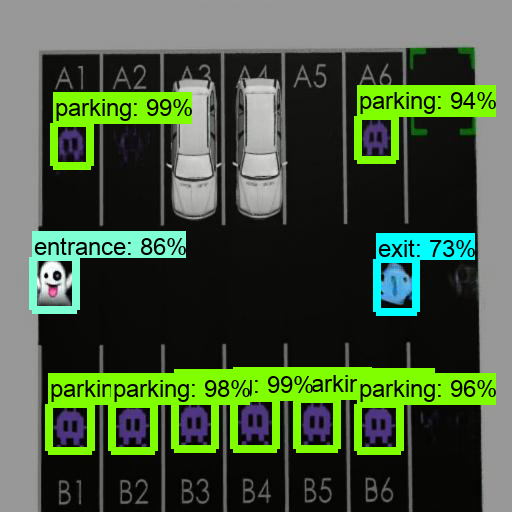

In [31]:
predictedImage = pix2pix()
coordenadas = objectDetection()
salida = findBestCoord(coordenadas)

#Go to selected cell

In [32]:
print(salida)

['B1', 141.92773266701613, 'parking', 91.86, 450.59]


In [33]:
!python ./moveTo.py "{salida[0]}"

02/12/2019 18:33:19.122226	_create_pomp_loop               Creating pomp loop
02/12/2019 18:33:19.123965	_create_manager                 New manager has been created!
02/12/2019 18:33:19.124636	_create_manager                 Manager device callbacks has been added to the manager
02/12/2019 18:33:19.125675	_create_net_backend             New net backend has been created
02/12/2019 18:33:19.126372	_create_net_backend             Set backend socket callback OK
02/12/2019 18:33:19.128245	_create_pomp_loop               Creating pomp loop
02/12/2019 18:33:19.130684	_create_pomp_loop               Creating pomp loop
02/12/2019 18:33:19.133857	create_timer                    Creating pomp timer
02/12/2019 18:33:19.134769	create_timer                    Creating pomp timer
Destination: B1
02/12/2019 18:33:19.139040	_start_net_discovery            Net discovery object has been created
I arsdkctrl: discovery 'net': start
02/12/2019 18:33:19.140932	_backend_socket_cb              backend_pointer

02/12/2019 18:33:19.309386	_recv_cmd_cb                    camera.ev_compensation(cam_id=0, value=ev_compensation.ev_0_00)
02/12/2019 18:33:19.311008	_recv_cmd_cb                    camera.style(cam_id=0, style=style.standard, saturation=0, saturation_min=-2, saturation_max=2, contrast=0, contrast_min=-2, contrast_max=2, sharpness=0, sharpness_min=-1, sharpness_max=1)
02/12/2019 18:33:19.312409	_recv_cmd_cb                    camera.recording_state(cam_id=0, available=availability.not_available, state=state.inactive, start_timestamp=625096)
02/12/2019 18:33:19.313831	_recv_cmd_cb                    ardrone3.MediaRecordState.VideoStateChangedV2(state=VideoStateChangedV2_State.notAvailable, error=VideoStateChangedV2_Error.ok)
02/12/2019 18:33:19.315276	_recv_cmd_cb                    camera.photo_state(cam_id=0, available=availability.available, state=state.inactive)
Traceback (most recent call last):
  File "_ctypes/callbacks.c", line 234, in 'calling callback function'
  File "/home/ro

02/12/2019 18:33:19.417242	_recv_cmd_cb                    wifi.ap_channel_changed(type=selection_type.auto_all, band=-1, channel=255)
02/12/2019 18:33:19.418725	_recv_cmd_cb                    wifi.country_changed(selection_mode=country_selection.auto, code='FR')
02/12/2019 18:33:19.420399	_recv_cmd_cb                    wifi.environment_changed(environment=environment.outdoor)
02/12/2019 18:33:19.422048	_recv_cmd_cb                    gimbal.gimbal_capabilities(gimbal_id=0, model=model.main, axes='pitch|roll')
02/12/2019 18:33:19.423610	_recv_cmd_cb                    gimbal.relative_attitude_bounds(gimbal_id=0, min_yaw=0.0, max_yaw=0.0, min_pitch=-135.0, max_pitch=105.0, min_roll=0.0, max_roll=0.0)
02/12/2019 18:33:19.425146	_recv_cmd_cb                    gimbal.absolute_attitude_bounds(gimbal_id=0, min_yaw=0.0, max_yaw=0.0, min_pitch=-90.0, max_pitch=90.0, min_roll=0.0, max_roll=0.0)
02/12/2019 18:33:19.426641	_recv_cmd_cb                    ardrone3.CameraState.VelocityRange(max_

02/12/2019 18:34:36.640070	_recv_cmd_cb                    ardrone3.PilotingState.moveToChanged(latitude=48.87890000000001, longitude=2.3677799999999998, altitude=3.0, orientation_mode=MoveToChanged_Orientation_mode.NONE, heading=88.58509826660156, status=MoveToChanged_Status.RUNNING)
02/12/2019 18:34:36.642121	_recv_cmd_cb                    animation.availability(values='horizontal_panorama|dronie|horizontal_reveal|vertical_reveal|twist_up')
02/12/2019 18:34:36.647628	_recv_cmd_cb                    animation.availability(values='')
02/12/2019 18:34:56.573498	_send_command                   Ardrone3.Piloting.Landing(): has been sent asynchronously
02/12/2019 18:34:56.649542	_recv_cmd_cb                    ardrone3.PilotingState.moveToChanged(latitude=48.87890000000001, longitude=2.3677799999999998, altitude=3.0, orientation_mode=MoveToChanged_Orientation_mode.NONE, heading=88.58509826660156, status=MoveToChanged_Status.CANCELED)
Traceback (most recent call last):
  File "_ctypes/call